In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.models import LDS
from ssm.util import random_rotation, find_permutation

In [2]:
# Set the parameters of the HMM
T = 50      # number of time bins per batch
B = 20      # number of batches
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_lds = LDS(N, D, emissions="poisson_nn", 
               emission_kwargs=dict(link="softplus", 
                                    hidden_layer_sizes=(50, 50))
              )
true_lds.dynamics.As[0] = .95 * random_rotation(D, theta=(1) * np.pi/20)

# Sample a bunch of short trajectories 
# (they all converge so we only learn from the initial condition)
zs, xs, ys = list(zip(*[true_lds.sample(T) for _ in range(B)]))

Text(0.5,1,'Simulated latent trajectories')

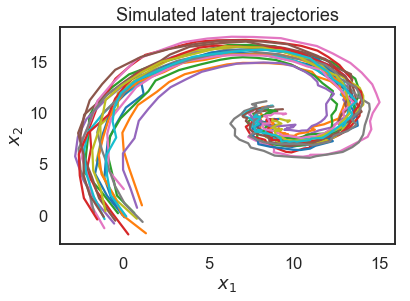

In [4]:
for x in xs:
    plt.plot(x[:, 0], x[:, 1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated latent trajectories")

Text(0.5,0.98,'Simulated firing rates')

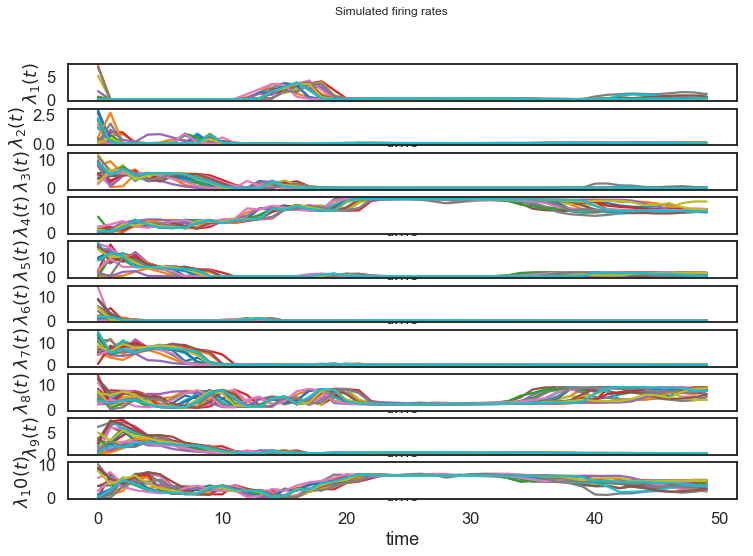

In [5]:
# Compute the firing rates
rates = [true_lds.smooth(x, y) for x, y in zip(xs, ys)]

plt.figure(figsize=(12, 8))
for n in range(N):
    plt.subplot(N, 1, n+1)
    for lmbda in rates:
        plt.plot(lmbda[:, n])
    plt.xlabel("time")
    plt.ylabel("$\\lambda_{}(t)$".format(n+1))
plt.suptitle("Simulated firing rates")

In [6]:
# Plot the nonlinear firing rate map for neuron 1
xmin, xmax = np.concatenate(xs).min(), np.concatenate(xs).max()
npts = 50
xx = np.linspace(xmin-1, xmax+1, npts)
XX, YY = np.meshgrid(xx, xx)
XY = np.column_stack((XX.ravel(), YY.ravel()))
tuning_curves = true_lds.smooth(XY, np.zeros((npts**2, N)))
assert np.all(tuning_curves > 0 )

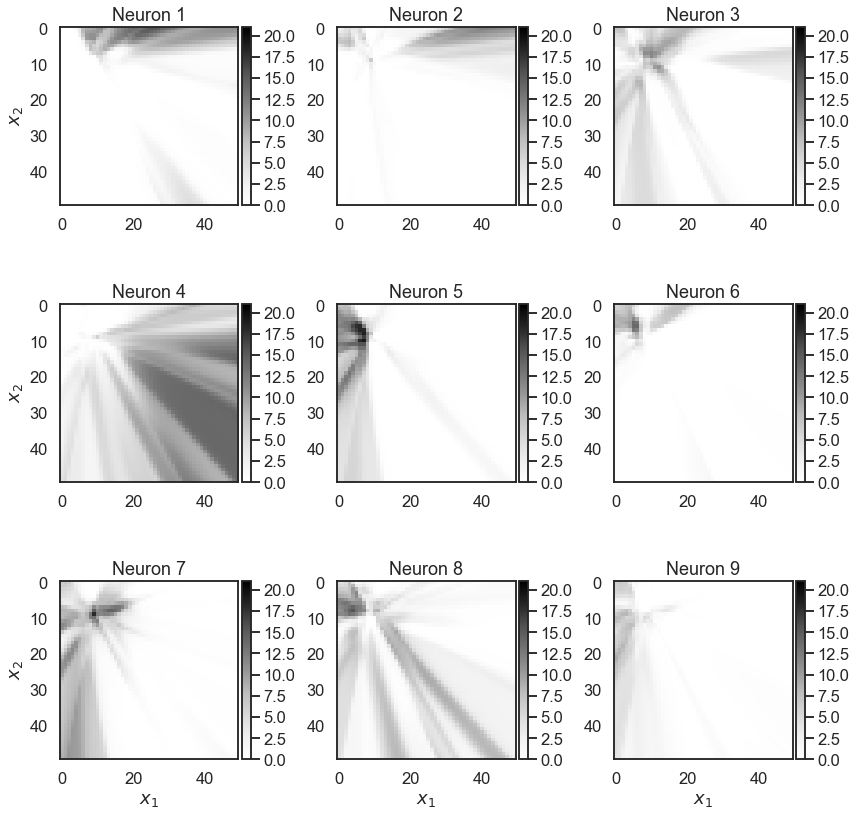

In [7]:
vmax = 1.1 * tuning_curves.max()
plt.figure(figsize=(12, 12))
splt = 3
for i in range(splt):
    for j in range(splt):
        n = i * splt + j 
        if n < N:
            ax = plt.subplot(splt, splt, n+1)
            im = plt.imshow(tuning_curves[:, n].reshape((npts, npts)), vmin=0, vmax=vmax, cmap="Greys")
            if i == splt-1:
                plt.xlabel("$x_1$")
            if j == 0:
                plt.ylabel("$x_2$")
                
            plt.title("Neuron {}".format(n+1))
            
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
plt.tight_layout()

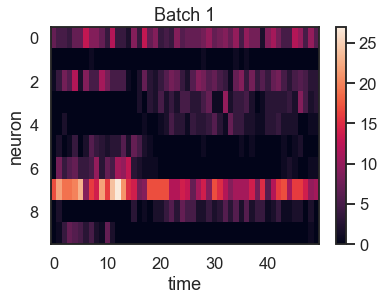

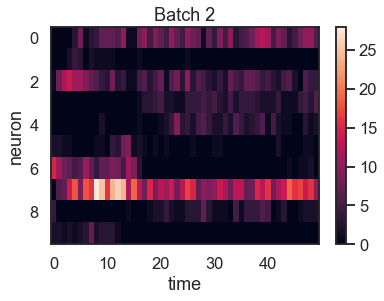

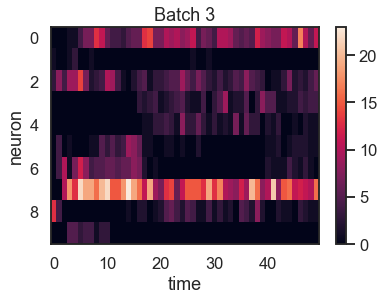

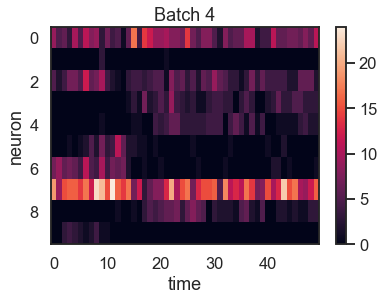

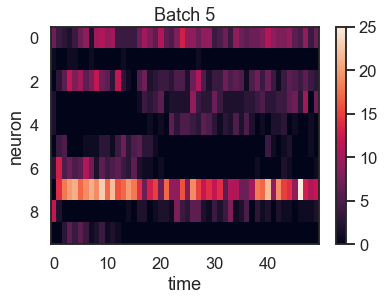

In [6]:
for b in range(5):
    plt.figure()
    plt.imshow(ys[b].T, aspect="auto", interpolation="none")
    plt.xlabel("time")
    plt.ylabel("neuron")
    plt.title("Batch {}".format(b+1))
    plt.colorbar()

In [8]:
print("Fitting LDS with SVI")
lds = LDS(N, D, emissions="poisson_nn", 
          emission_kwargs=dict(link="softplus", 
                               hidden_layer_sizes=(50, 50))
         )
lds_elbos, variational_params = lds.fit(ys, num_iters=10000, print_intvl=100)
lds_xs = [vp[0] for vp in variational_params]

Fitting LDS with SVI
Initializing with an ARHMM using 25 steps of EM.
Done
Iteration 0.  ELBO: -86229.4
Iteration 100.  ELBO: -31505.0
Iteration 200.  ELBO: -24781.8
Iteration 300.  ELBO: -22988.0
Iteration 400.  ELBO: -22029.6
Iteration 500.  ELBO: -21517.3
Iteration 600.  ELBO: -21088.2
Iteration 700.  ELBO: -20782.4
Iteration 800.  ELBO: -20745.0
Iteration 900.  ELBO: -20381.7
Iteration 1000.  ELBO: -20498.2
Iteration 1100.  ELBO: -20213.3
Iteration 1200.  ELBO: -20372.0
Iteration 1300.  ELBO: -20209.7
Iteration 1400.  ELBO: -20117.0
Iteration 1500.  ELBO: -20131.7
Iteration 1600.  ELBO: -20025.8
Iteration 1700.  ELBO: -20111.8
Iteration 1800.  ELBO: -19904.8
Iteration 1900.  ELBO: -19843.1
Iteration 2000.  ELBO: -19895.5
Iteration 2100.  ELBO: -19850.6
Iteration 2200.  ELBO: -19850.3
Iteration 2300.  ELBO: -19902.0
Iteration 2400.  ELBO: -19729.9
Iteration 2500.  ELBO: -19748.7
Iteration 2600.  ELBO: -19705.7
Iteration 2700.  ELBO: -19648.7
Iteration 2800.  ELBO: -19586.1
Iteration

Text(0,0.5,'ELBO')

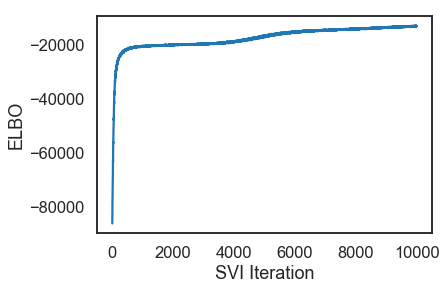

In [9]:
plt.plot(lds_elbos)
plt.xlabel("SVI Iteration")
plt.ylabel("ELBO")

In [10]:
# Smooth the observations
lds_ys = [lds.smooth(x, y) for x, y in zip(lds_xs, ys)]

(0, 50)

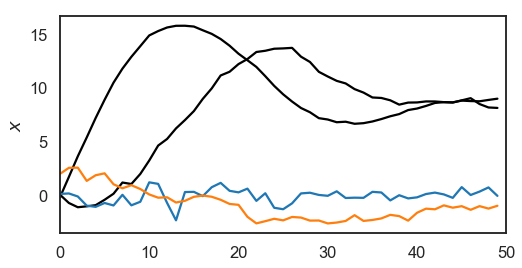

In [11]:
plt.figure(figsize=(8,4))
plt.plot(xs[0], '-k')
plt.plot(lds_xs[0], '-')
plt.ylabel("$x$")
plt.xlim(0, T)

(0, 50)

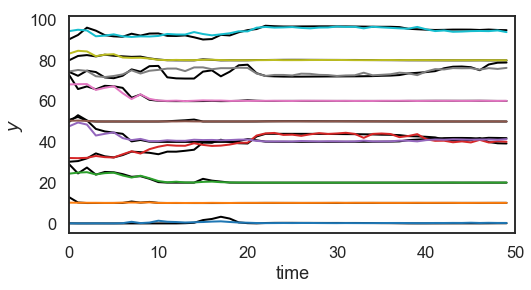

In [15]:
# Plot the smoothed observations
plt.figure(figsize=(8,4))
plt.plot(rates[0] + 10 * np.arange(N), '-k', lw=2)
plt.plot(lds_ys[0] + 10 * np.arange(N), '-', lw=2)
plt.ylabel("$y$")
plt.xlabel("time")
plt.xlim(0, T)